In [58]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

In [7]:
Y_START, Y_END = 25, 35
X_START, X_END = 0, 1315

In [8]:
def imread_gs(path: str) -> np.ndarray:
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def crop(img: np.ndarray,
         x_params: tuple[int, int] = (X_START, X_END),
         y_params: tuple[int, int] = (Y_START, Y_END)
        ) -> np.ndarray:
    return img[y_params[0]:y_params[1], x_params[0]:x_params[1]]


def show(img: np.ndarray) -> None:
    plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap='gray')

In [9]:
pmma_img = imread_gs('data/pmma_192648.tif')
benzo_img = imread_gs('data/benzoic1000msgain_193519.tif')

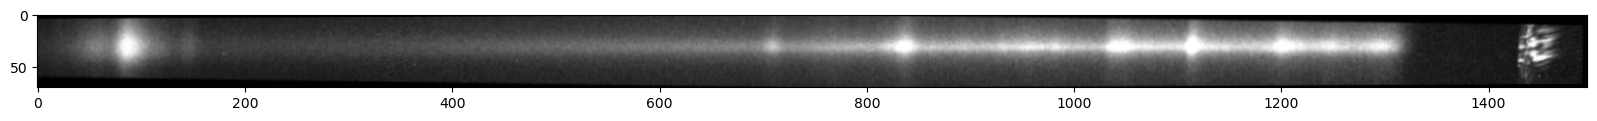

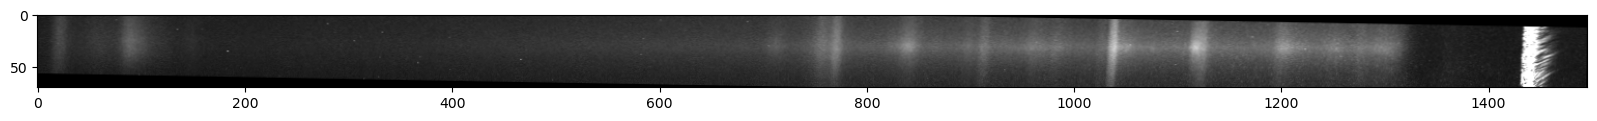

In [10]:
show(pmma_img)
show(benzo_img)

In [11]:
pmma_img.shape

(70, 1496)

In [12]:
benzo_img.shape

(70, 1496)

In [13]:
pmma_cropped = crop(pmma_img)
benzo_cropped = crop(benzo_img)

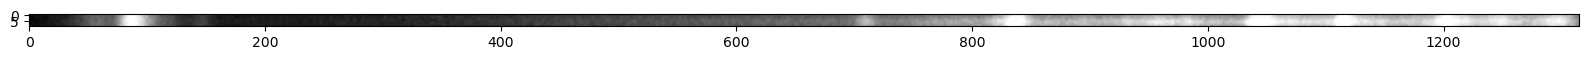

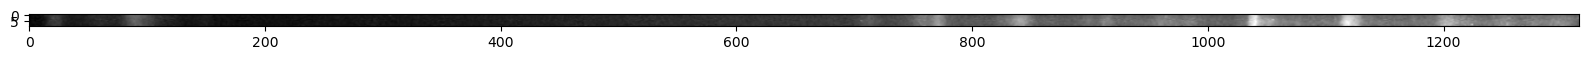

In [14]:
show(pmma_cropped)
show(benzo_cropped)

In [16]:
pmma_spec = pmma_cropped.sum(axis=0, dtype=np.int64)
benzo_spec = benzo_cropped.sum(axis=0, dtype=np.int64)

# trying to process in wavelength space

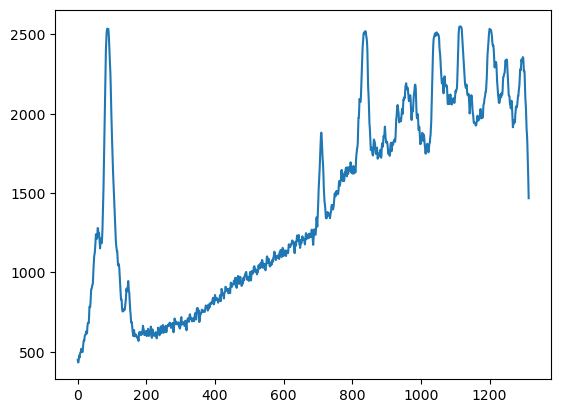

In [129]:
plt.plot(pmma_spec)

[  88  145  710  836  895  958  981 1045 1115 1203 1247 1295]


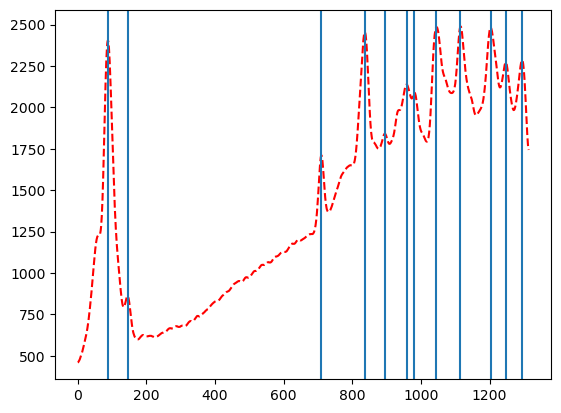

In [70]:
pmma_smoothed = gaussian_filter(pmma_spec, 5)
pmma_peaks = find_peaks(pmma_smoothed, prominence=15)[0]
print(pmma_peaks)

plt.plot(pmma_smoothed, 'r--')
for x in pmma_peaks:
    plt.axvline(x)

[  22   91  148  713  769  840  914  963 1040 1120 1204 1252 1297]


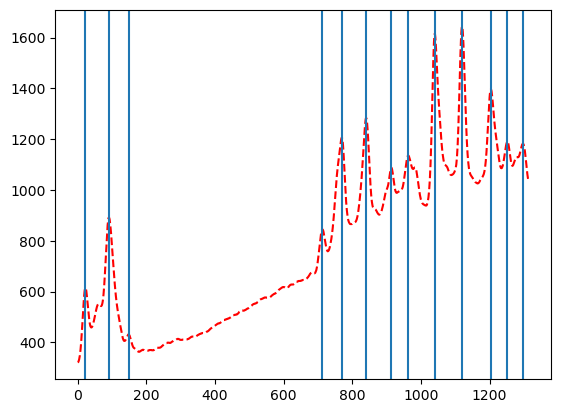

In [71]:
benzo_smoothed = gaussian_filter(benzo_spec, 5)
benzo_peaks = find_peaks(benzo_smoothed, prominence=15)[0]
print(benzo_peaks)

plt.plot(benzo_smoothed, 'r--')
for x in benzo_peaks:
    plt.axvline(x)

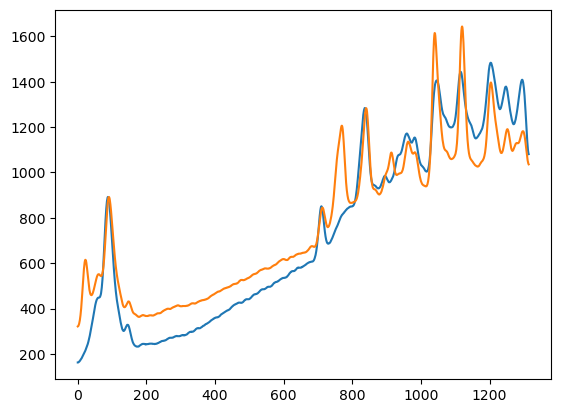

In [89]:
alpha = (benzo_smoothed[91]/pmma_smoothed[88] - benzo_smoothed[840]/pmma_smoothed[836])/(88-836)
beta = benzo_smoothed[91]/pmma_smoothed[88] - alpha * 88

ps_n = np.empty_like(pmma_smoothed)
for x, y in enumerate(pmma_smoothed):
    ps_n[x] = (alpha * x + beta) * y

plt.plot(ps_n)
plt.plot(benzo_smoothed)

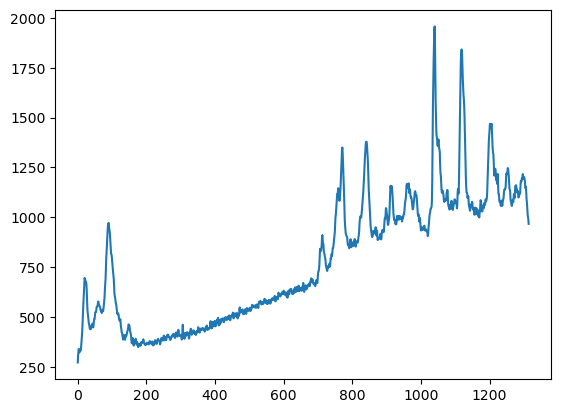

In [130]:
plt.plot(benzo_spec)

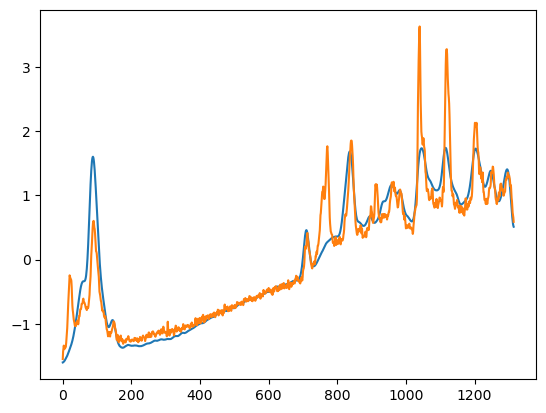

In [82]:
pmma_mean = np.mean(pmma_smoothed)
pmma_std = np.std(pmma_smoothed)
pmma_smoothed_normalized = (pmma_smoothed - pmma_mean)/pmma_std

benzo_mean = np.mean(benzo_spec)
benzo_std = np.std(benzo_spec)
benzo_spec_normalized = (benzo_spec - benzo_mean)/benzo_std

plt.plot(pmma_smoothed_normalized)
plt.plot(benzo_spec_normalized)

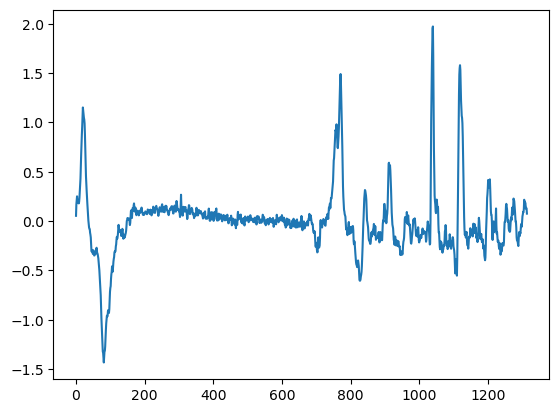

In [83]:
plt.plot(benzo_spec_normalized - pmma_smoothed_normalized)

# reference spectrum of benzoic acid

In [52]:
def readline(line: str) -> tuple[float, float]:
    x, y = line.split('  ')
    return (float(x), float(y))

In [53]:
with open('data/benzoic acid reference.txt') as f:
    benzo_ref = [ readline(l) for l in f.readlines() ]

In [54]:
wvns, vals = np.array(benzo_ref).transpose()
wvls = 2*np.pi/wvns

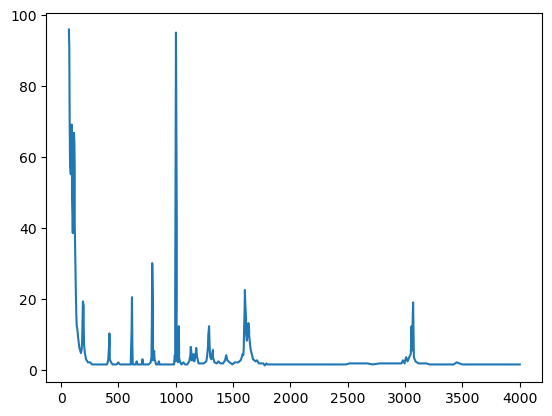

In [145]:
plt.plot(wvns, vals)

# trying to process in wavenumber space

[  88  145  710  836  895  958  981 1045 1115 1203 1247 1295]


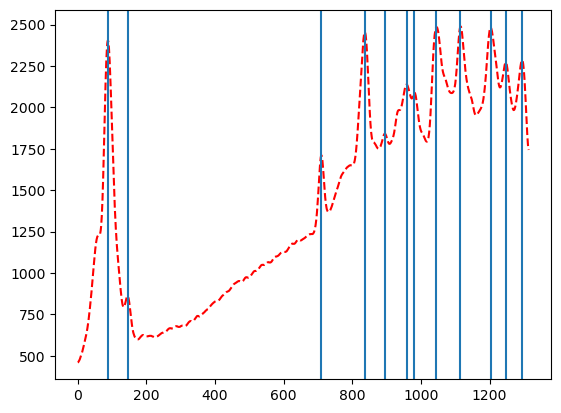

In [100]:
print(pmma_peaks)

plt.plot(pmma_smoothed, 'r--')
for x in pmma_peaks:
    plt.axvline(x)

[  22   91  148  713  769  840  914  963 1040 1120 1204 1252 1297]


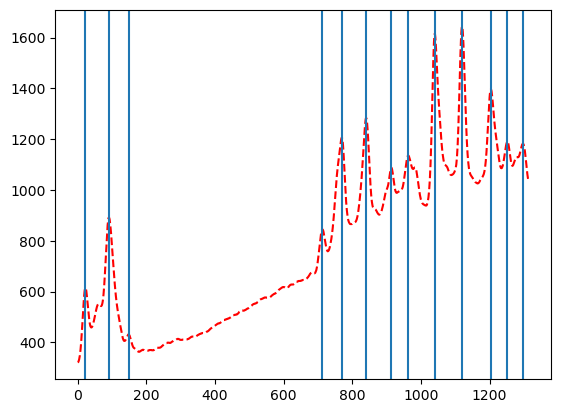

In [101]:
print(benzo_peaks)

plt.plot(benzo_smoothed, 'r--')
for x in benzo_peaks:
    plt.axvline(x)

In [121]:
ref_wvn  = [ 812.86, 976.28, 1451.9, 1728.9, 2844.9, 2952 ]
pmma_pn  = [ 1115, 1045, 836, 710, 145, 88 ]
benzo_pn = [ 1120, 1040, 840, 713, 148, 91 ]

pmma_fit  = np.poly1d(np.polyfit(pmma_pn, ref_wvn, 3))
benzo_fit = np.poly1d(np.polyfit(benzo_pn, ref_wvn, 3))

pmma_wvn  = pmma_fit(np.arange(0, len(pmma_spec)))
benzo_wvn = benzo_fit(np.arange(0, len(benzo_spec)))

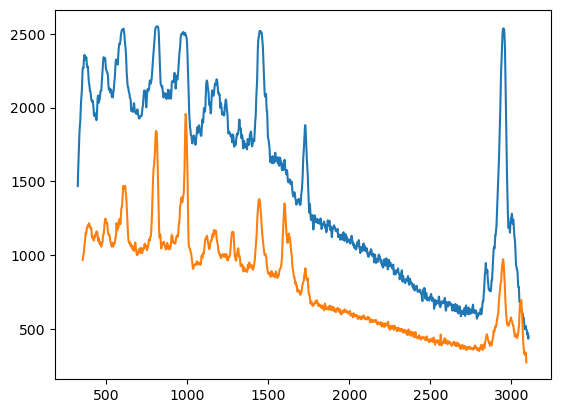

In [126]:
plt.plot(pmma_wvn, pmma_spec)
plt.plot(benzo_wvn, benzo_spec)

In [127]:
pmma_mean = np.mean(pmma_spec)
pmma_std = np.std(pmma_spec)
pmma_spec_normalized = (pmma_spec - pmma_mean)/pmma_std

benzo_mean = np.mean(benzo_spec)
benzo_std = np.std(benzo_spec)
benzo_spec_normalized = (benzo_spec - benzo_mean)/benzo_std

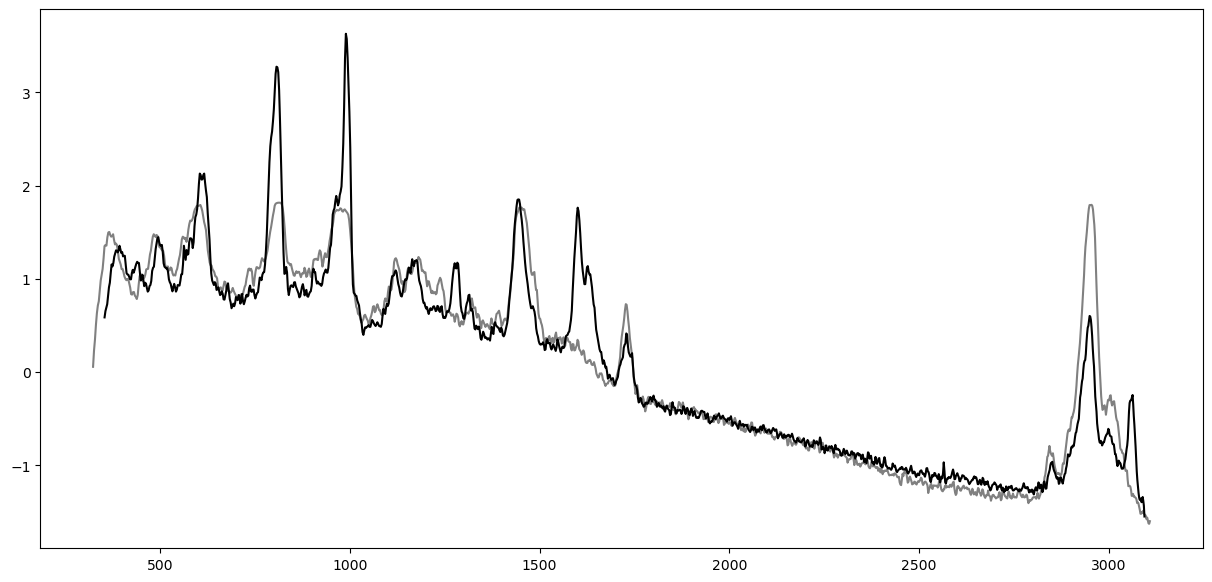

In [136]:
plt.figure(figsize=(15, 7))
plt.plot(pmma_wvn, pmma_spec_normalized, c='gray')
plt.plot(benzo_wvn, benzo_spec_normalized, c='black')

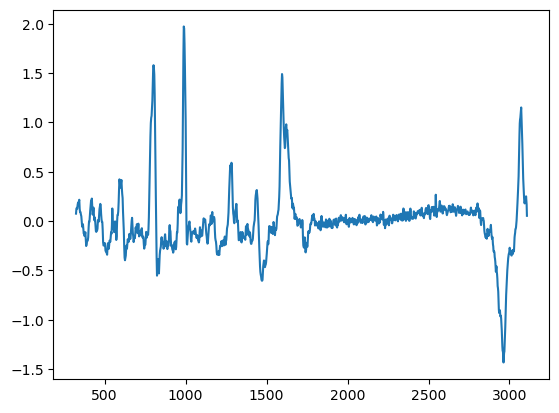

In [137]:
plt.plot(pmma_wvn, benzo_spec_normalized - pmma_smoothed_normalized)